# ANU ASTR4004 2024 - Week 8 (24+26 September 2024)

Author: Dr Sven Buder (sven.buder@anu.edu.au)

Based heavily on the Python Data Science Handbook by Jake VanderPlas:  https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html#What-do-the-components-mean?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Let's-try-a-different-data-set:-images-of-numbers" data-toc-modified-id="Let's-try-a-different-data-set:-images-of-numbers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Let's try a different data set: images of numbers</a></span></li><li><span><a href="#Let's-try-Principal-Component-Analysis-first" data-toc-modified-id="Let's-try-Principal-Component-Analysis-first-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Let's try Principal Component Analysis first</a></span><ul class="toc-item"><li><span><a href="#Why-would-you-want-to-use-PCA?" data-toc-modified-id="Why-would-you-want-to-use-PCA?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Why would you want to use PCA?</a></span></li><li><span><a href="#Disadvantages-of-PCA" data-toc-modified-id="Disadvantages-of-PCA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Disadvantages of PCA</a></span></li></ul></li><li><span><a href="#t-distributed-Stochastic-Neighbour-Embedding-(tSNE)" data-toc-modified-id="t-distributed-Stochastic-Neighbour-Embedding-(tSNE)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>t-distributed Stochastic Neighbour Embedding (tSNE)</a></span><ul class="toc-item"><li><span><a href="#UMAP" data-toc-modified-id="UMAP-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>UMAP</a></span></li></ul></li></ul></div>

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches

# Make the size and fonts larger for this presentation
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Let's try a different data set: images of numbers

In [2]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

In [3]:
# Load digits dataset
digits = load_digits()
X = digits.data
y = digits.target

np.shape(X), np.shape(y)

((1797, 64), (1797,))

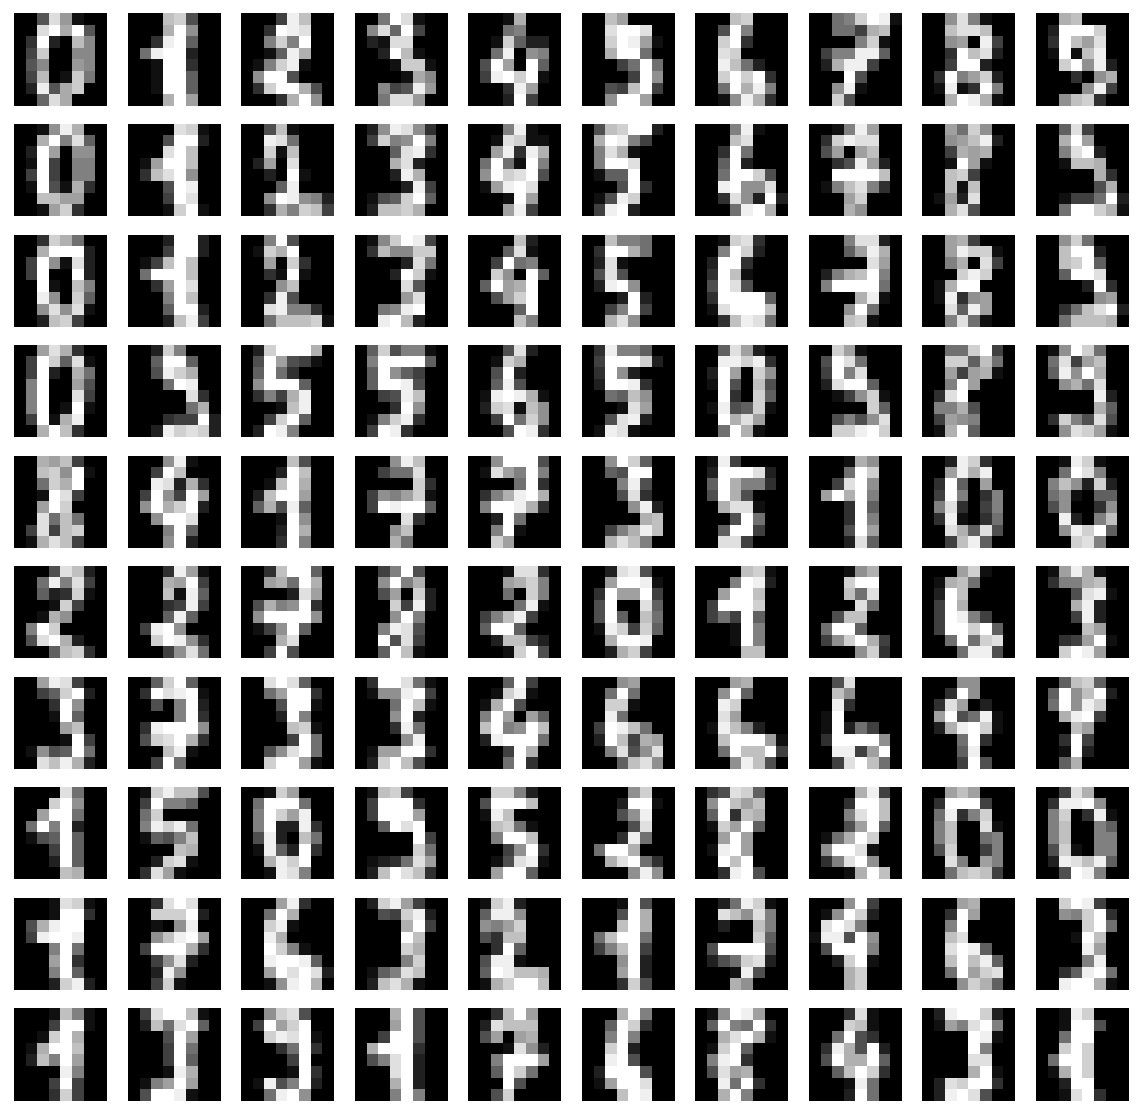

In [4]:
# Let's visualize the first few images from the digits dataset
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.axis('off')

plt.show()

In [5]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Let's try Principal Component Analysis first

In [6]:
# Re-importing libraries if necessary
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the digits dataset
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X_scaled)
print(X_scaled.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


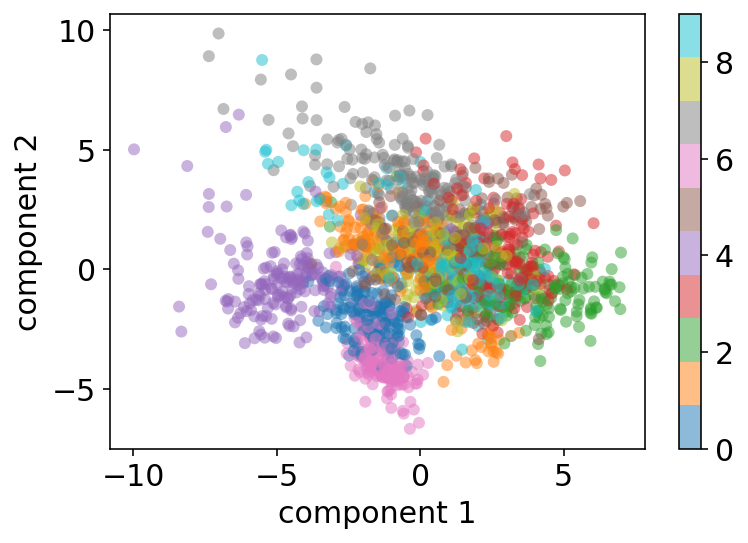

In [7]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap='tab10')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

In [8]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

**What do the components mean?**

We can go a bit further here, and begin to ask what the reduced dimensions mean. This meaning can be understood in terms of combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$x=[x_1,x_2,x_3,...,x_{64}]$$
 
One way we can think about this is in terms of a pixel basis. That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$image(x)=x1⋅(pixel 1)+x2⋅(pixel 2)+x3⋅(pixel 3)⋯x64⋅(pixel 64)$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors. For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

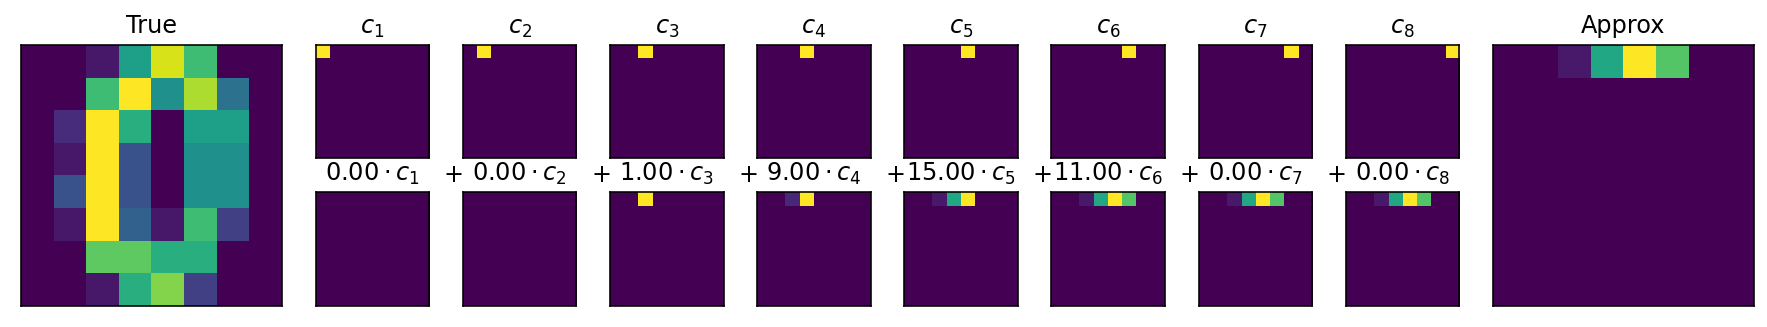

In [9]:
fig = plot_pca_components(digits.data[10],
                          show_mean=False)

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$ image(x)=mean+x1⋅(basis 1)+x2⋅(basis 2)+x3⋅(basis 3) ... $$

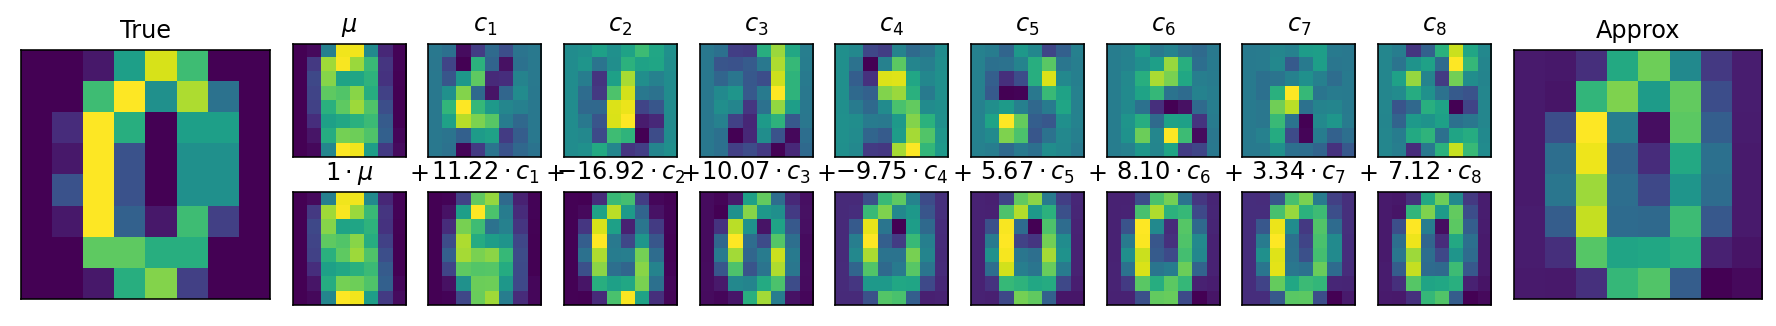

In [10]:
pca = PCA(n_components=8)
Xproj = pca.fit_transform(digits.data)

fig = plot_pca_components(digits.data[10], Xproj[10],
                          pca.mean_, pca.components_)

### Why would you want to use PCA?

- Simplicity and Speed (no iterative optimization required)
- Capturing Maximum Variance (PCA can find dimensions that explain most of the variation of the data)
- Deterministic (you will get the same result every time you run the algorithm)
- Preserve Global Structure (large distances between clusters or points are well captured in the projection)

### Disadvantages of PCA

- Linear Relationships (only captures linear relationships between features)
- Loss of Local Structure (PCA focuses on variance maximization: points that are close together in the original high-dimensional space might not remain close in the low-dimensional PCA projection)
- Explaining Variance vs. Interpretability (principal components themselves may not be easily interpretable; doesn’t necessarily provide an easily interpretable 2D map for complex datasets)
- Not Optimized for Clustering (if you want to cluster data, may not separate these clusters effectively)

## t-distributed Stochastic Neighbour Embedding (tSNE)

In [11]:
# Apply t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=462)
X_tsne = tsne.fit_transform(X_scaled)

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


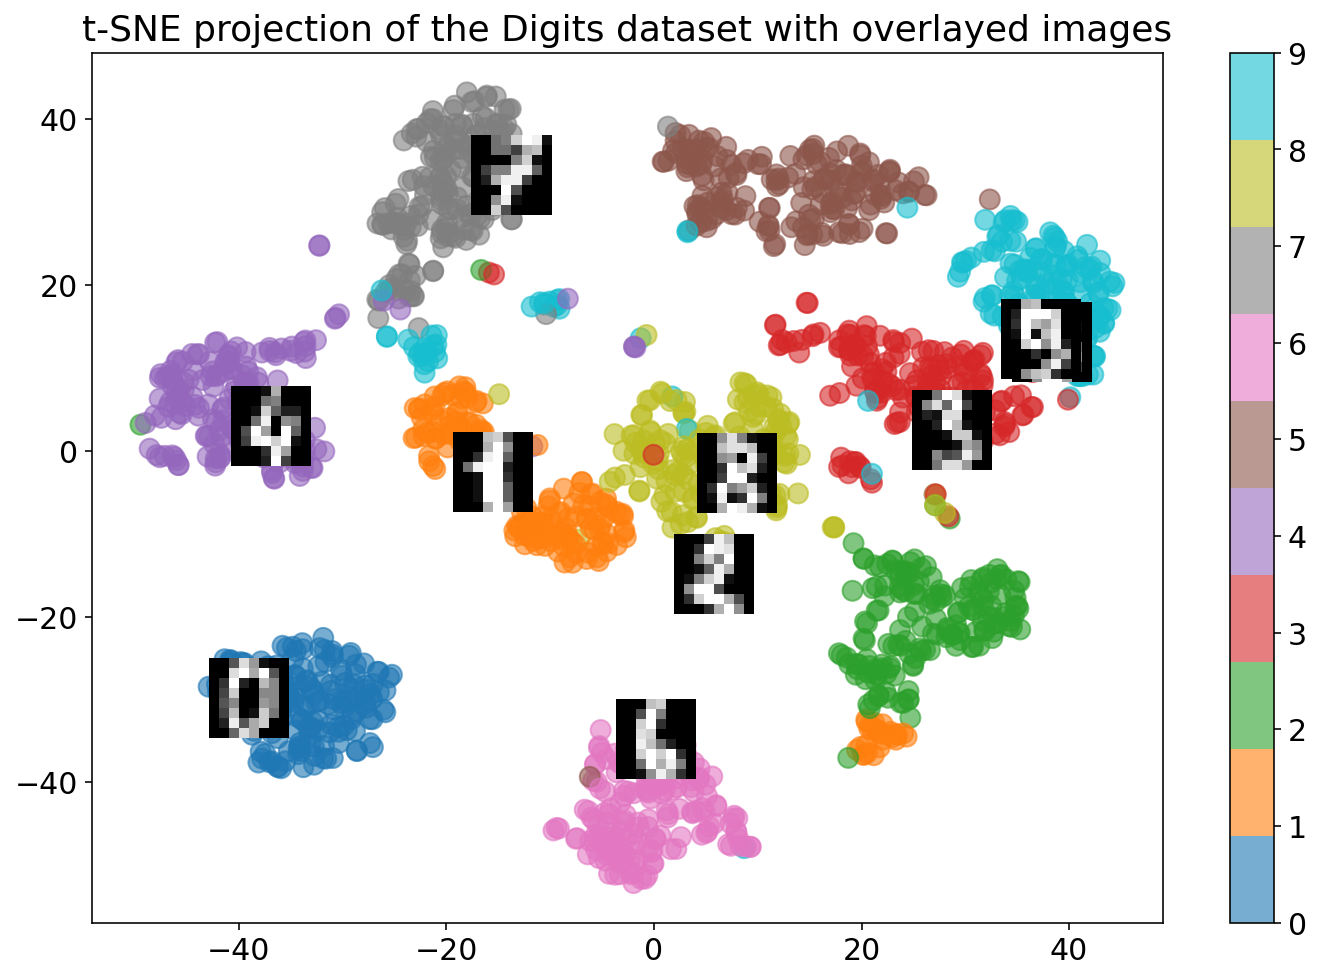

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create the t-SNE plot with images overlayed
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=100, alpha=0.6)
plt.colorbar()
plt.title('t-SNE projection of the Digits dataset with overlayed images')

# Function to place images on the scatter plot
def imscatter(x, y, images, ax=None, zoom=5):
    if ax is None:
        ax = plt.gca()
    for i in range(len(images)):
        image = OffsetImage(images[i], zoom=zoom, cmap='gray')
        ab = AnnotationBbox(image, (x[i], y[i]), xycoords='data', frameon=False)
        ax.add_artist(ab)

# Select a few random images to overlay on the plot
images_to_overlay = digits.images[:10]  # Choosing the first 10 images for clarity
x_positions = X_tsne[:10, 0]  # Corresponding x positions in the t-SNE space
y_positions = X_tsne[:10, 1]  # Corresponding y positions in the t-SNE space

# Overlay images
imscatter(x_positions, y_positions, images_to_overlay)

plt.show()

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


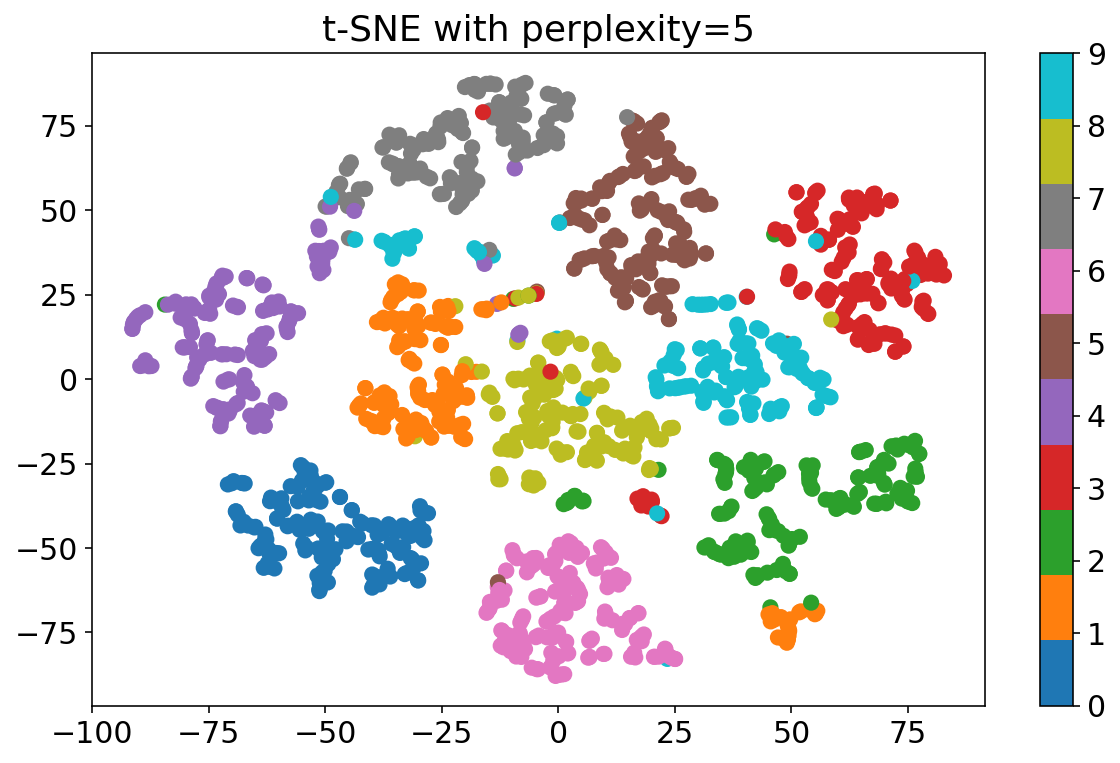

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


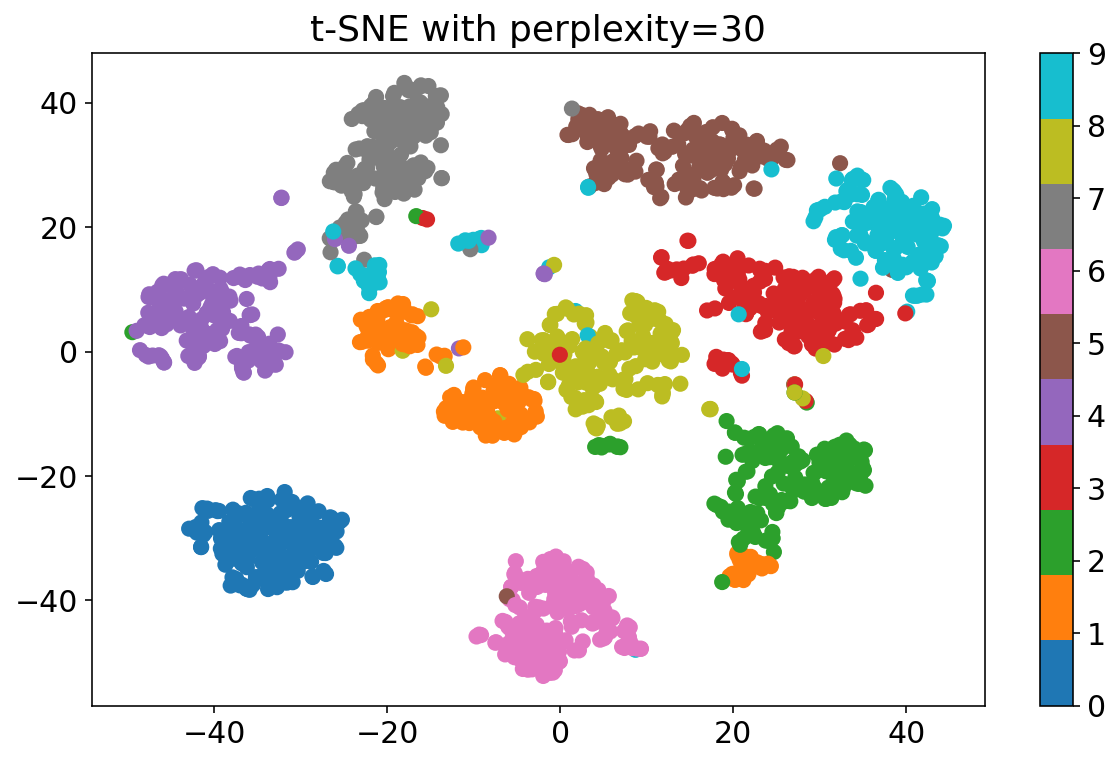

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


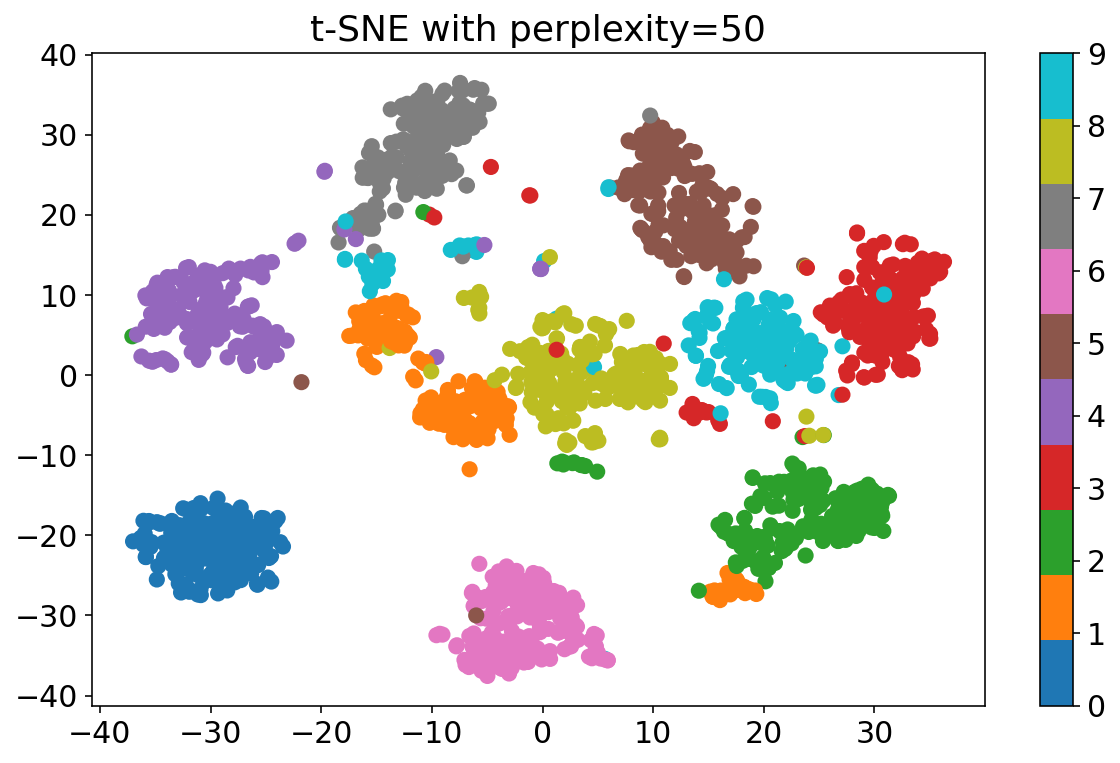

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


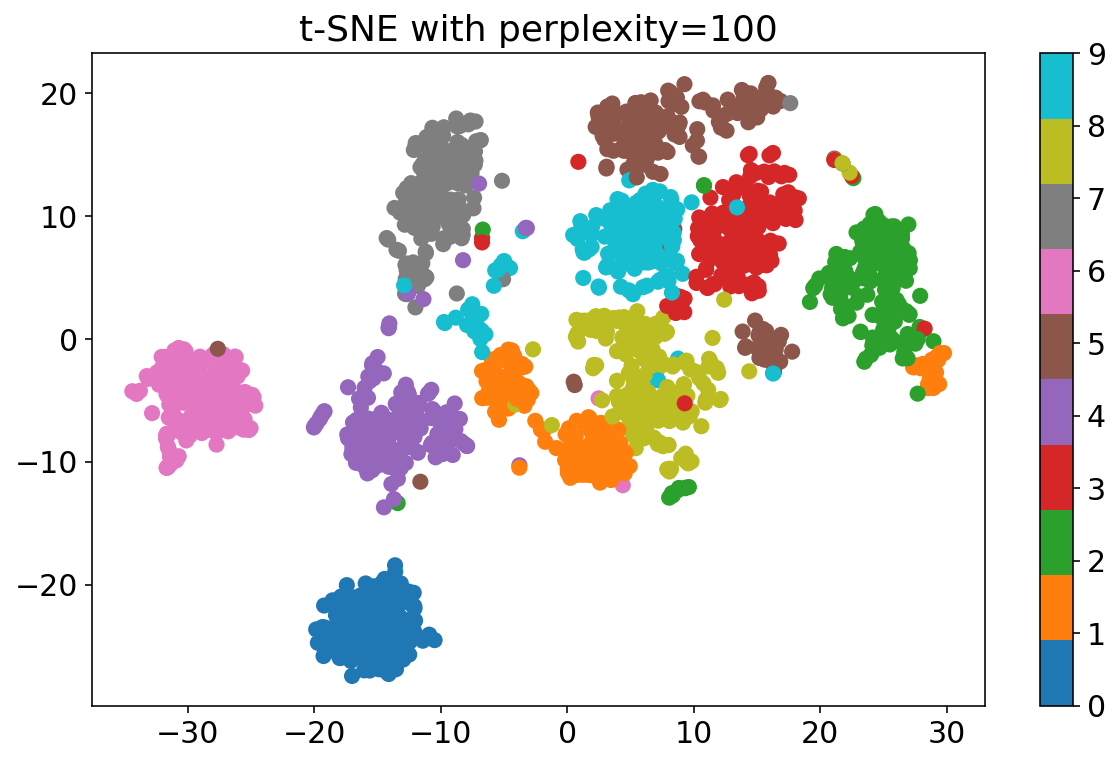

In [13]:
# Try different perplexities
for perplexity in [5, 30, 50, 100]:
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=462)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=50)
    plt.colorbar()
    plt.title(f't-SNE with perplexity={perplexity}')
    plt.show()